In [1]:
import numpy as np
from Py6S import *
import time as T
from joblib import Parallel, delayed
from scipy.interpolate import griddata,interpn,RegularGridInterpolator
import math
import os
import datetime
import cv2
from ftplib import FTP
import rioxarray
import xarray as xr
import multiprocessing
import paramiko
from scp import SCPClient
import subprocess

/data01/people/liwei/anaconda3/envs/python36/lib/python3.6/site-packages/paramiko/transport.py:33: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [2]:
sza = np.linspace(0,80,17)
vza = np.linspace(0,80,17)
water = np.linspace(0,7,8)
ozone = np.linspace(0.2,0.4,5)
AOT = np.array([0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0])
raa = np.linspace(0,180,19)
al = np.linspace(0,8,5)
aero_type = np.array([0,1])

LUT_PATH = '/data01/GEO/INPUT/LUT/'

In [3]:
OZONE = np.random.uniform(0.2,0.4,1000)
WATER = np.random.uniform(0,7,1000)
aot = np.random.uniform(0.01,1,1000)
SZA = np.random.uniform(0,60,1000)
VZA = np.random.uniform(0,60,1000)
RAA = np.random.uniform(0,180,1000)

AL = np.random.uniform(0,5,1000)
AERO_TYPE = np.random.randint(2, size=1000)

In [4]:

class LUT_interpolation:
    def __init__(self,LUT_path):
        self.LUT_path = LUT_path
    
    def LUT_interpolation_Linear(self):
        
        X1 = np.loadtxt(self.LUT_path + "01_band6.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "02_band6.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "03_band6.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        # return X1, X2, X3
        
        fn1 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan)
        fn2 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan)
        fn3 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan)
        return fn1,fn2,fn3
    def LUT_interpolation_Nearest(self):
        
        X1 = np.loadtxt(self.LUT_path + "01_band6.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "02_band6.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "03_band6.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
        # return X1, X2, X3
        
        fn1 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan,method = 'nearest')
        fn2 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan,method = 'nearest')
        fn3 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan,method = 'nearest')
        return fn1,fn2,fn3
    
#     def LUT_interpolation_Cubic(self):
        
#         X1 = np.loadtxt(self.LUT_path + "01_band4.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
#         X2 = np.loadtxt(self.LUT_path + "02_band4.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
#         X3 = np.loadtxt(self.LUT_path + "03_band4.csv",delimiter=",").reshape(2,8,12,5,17,17,19)
#         # return X1, X2, X3
        
#         fn1 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X1,bounds_error=False,fill_value=np.nan,method = "cubic")
#         fn2 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X2,bounds_error=False,fill_value=np.nan,method = "cubic")
#         fn3 = RegularGridInterpolator((aero_type,water,AOT,al,sza,vza,raa),X3,bounds_error=False,fill_value=np.nan,method = "cubic")
#         return fn1,fn2,fn3
    
    

fn1_L,fn2_L,fn3_L = LUT_interpolation(LUT_PATH).LUT_interpolation_Linear()
fn1_N,fn2_N,fn3_N = LUT_interpolation(LUT_PATH).LUT_interpolation_Nearest()
# fn1_C,fn2_C,fn3_C = LUT_interpolation(LUT_PATH).LUT_interpolation_Cubic()



In [5]:
xa_LUT_N = []
xb_LUT_N = []
xc_LUT_N = []

for i in range(1000):
    xi = np.array([AERO_TYPE[i],WATER[i],aot[i],AL[i],SZA[i],VZA[i],RAA[i]])
    xi = xi.T
    xa_LUT_N.append(fn1_N(xi))
    xb_LUT_N.append(fn2_N(xi))
    xc_LUT_N.append(fn3_N(xi))
    
xa_LUT_N = np.array(xa_LUT_N)
xb_LUT_N= np.array(xb_LUT_N)
xc_LUT_N = np.array(xc_LUT_N)

xa_LUT_L = []
xb_LUT_L = []
xc_LUT_L = []

for i in range(1000):
    xi = np.array([AERO_TYPE[i],WATER[i],aot[i],AL[i],SZA[i],VZA[i],RAA[i]])
    xi = xi.T
    xa_LUT_L.append(fn1_L(xi))
    xb_LUT_L.append(fn2_L(xi))
    xc_LUT_L.append(fn3_L(xi))
    
xa_LUT_L = np.array(xa_LUT_L)
xb_LUT_L= np.array(xb_LUT_L)
xc_LUT_L = np.array(xc_LUT_L)

# xa_LUT_C = []
# xb_LUT_C = []
# xc_LUT_C = []

# for i in range(1000):
#     xi = np.array([AERO_TYPE[i],WATER[i],aot[i],AL[i],SZA[i],VZA[i],RAA[i]])
#     xi = xi.T
#     xa_LUT_C.append(fn1_L(xi))
#     xb_LUT_C.append(fn2_L(xi))
#     xc_LUT_C.append(fn3_L(xi))
    
# xa_LUT_C = np.array(xa_LUT_C)
# xb_LUT_C= np.array(xb_LUT_C)
# xc_LUT_C = np.array(xc_LUT_C)


In [6]:

def sixS(i):
    AERO = AERO_TYPE + 1
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(WATER[i],0.3)
    s.aero_profile = AeroProfile.PredefinedType(AERO[i])
    s.aot550 = aot[i]
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(AL[i])
    s.geometry = Geometry.User()
    s.geometry.solar_z = SZA[i]
    s.geometry.solar_a = RAA[i]
    s.geometry.view_z = VZA[i]
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [7]:
wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band6.csv"
band = np.loadtxt(wl_band,delimiter=",")
AC_output = Parallel(n_jobs=-1)(delayed(sixS)(i) \
                                for i in range (1000))

In [8]:
X=np.array(AC_output)
X1=X[:,0]
X2=X[:,1]
X3=X[:,2]

In [9]:
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
def parameter(a,b):
    r2 = r2_score(a, b)
    r2 = np.around(r2,4)
    # k = np.polyfit(a, b,1)[0][0]
    # b = np.polyfit(a, b,1)[1][0]
    # k = np.around(k,4)
    # b = np.around(b,4)
    rmse = np.sqrt(mean_squared_error(a ,b))
    rmse = round(rmse.astype('float64'),3)
    return rmse,r2

In [10]:
rmse1_N,r21_N = parameter(X1,xa_LUT_N)
rmse1_L,r21_L = parameter(X1,xa_LUT_L)

rmse2_N,r22_N = parameter(X2,xb_LUT_N)
rmse2_L,r22_L = parameter(X2,xb_LUT_L)

rmse3_N,r23_N = parameter(X3,xc_LUT_N)
rmse3_L,r23_L = parameter(X3,xc_LUT_L)

In [11]:
def make_fig(i,axis_max,axis_min,_6S,_LUT_N,_LUT_L,factor,rmse_N,rmse_L,r2_N,r2_L):
    
    ax1 = axes[i]
 
    x = np.arange(axis_min,axis_max+1)
    y = 1 * x

    ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
    ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

    ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
    ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')


    ax1.scatter(_6S,_LUT_N,marker='o',s=25,c='k',label='Nearest')
    ax1.scatter(_6S,_LUT_L,marker='o',s=25,c='r',label='Linear')


    ax1.set_xticks(np.linspace(axis_min,axis_max,5))
    ax1.set_yticks(np.linspace(axis_min,axis_max,5))
    
    ax1.set_xlabel("X{} by 6S".format(factor),fontsize=10)
    ax1.set_ylabel("X{} by LUT".format(factor),fontsize=10)

    ax1.plot(x,y,color='y',linewidth=2,linestyle='-',zorder=2)


    text_x = axis_min + (axis_max - axis_min) * 0.05
    text_y = axis_max - (axis_max - axis_min) * 0.15

    ax1.text(text_x,text_y,s = 'NN RMSE = {}\nNN R2 = {}\n'.format(rmse_N,r2_N),fontsize=8)
    ax1.text(text_x,text_y-(axis_max - axis_min) * 0.05,s = 'Linear RMSE = {}\nLinear R2 = {}'.format(rmse_L,r2_L),fontsize=8,c='r')
    
    ax1.set_xlim(axis_min,axis_max)
    ax1.set_ylim(axis_min,axis_max)

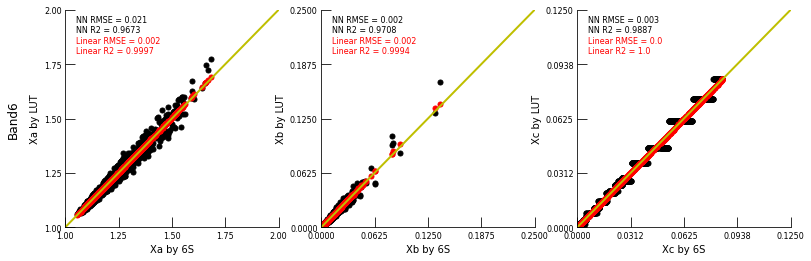

In [12]:
fig ,axes = plt.subplots(1,3, figsize=(13, 4))


make_fig(0,2,1,X1,xa_LUT_N,xa_LUT_L,'a',rmse1_N,rmse1_L,r21_N,r21_L)
make_fig(1,0.25,0,X2,xb_LUT_N,xb_LUT_L,'b',rmse2_N,rmse1_L,r22_N,r22_L)
make_fig(2,0.125,0,X3,xc_LUT_N,xc_LUT_L,'c',rmse3_N,rmse3_L,r23_N,r23_L)
plt.suptitle('Band6',fontsize=12,y=0.57,x=0.07,rotation=90)
fig.savefig('LUT_B06.jpg',dpi = 1000,bbox_inches = 'tight')
plt.show()